# Setup environment

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

!git clone https://github.com/sustainlab-group/sustainbench.git /content/drive/MyDrive/sustainbench


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
fatal: destination path '/content/drive/MyDrive/sustainbench' already exists and is not an empty directory.


In [ ]:
%cd /content/drive/MyDrive/sustainbench

!pip install -q condacolab
import condacolab
condacolab.install()

# Create the Conda environment from the .yml file
!conda env create -f /content/drive/MyDrive/sustainbench/env_bench.yml

[Errno 2] No such file or directory: '/content/drive/MyDrive/sustainbench'
/content
⏬ Downloading https://github.com/conda-forge/miniforge/releases/download/23.11.0-0/Mambaforge-23.11.0-0-Linux-x86_64.sh...
📦 Installing...


KeyboardInterrupt: 

In [108]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import time
from datetime import datetime
import math
from sklearn.metrics import r2_score, mean_squared_error
from tensorflow.keras.layers import Dense, LSTM
import itertools
import torch
from torch.utils.data import Dataset, DataLoader
import pandas as pd


# 1. LSTM Baseline Model

## Build the lstm model

This LSTM_NeuralModel references from the oringial paper's github:  https://github.com/AnnaXWang/deep-transfer-learning-crop-prediction/blob/master/code/nnet_LSTM.py.

And modified some codes to meet the updated Implementation reuqirement for TensorFlow 2.x.

In [ ]:

class LSTM_Config():
    B, W, C = 32,32,9
    H = 32 #all season lengths will be 32
    loss_lambda = 0.75
    lstm_layers = 1
    lstm_H = 200
    dense = 356
    season_len = 32

    train_step = 10000000
    lr = 0.005
    #keep probability
    drop_out = 0.75

    def __init__(self, season_frac=None):
        if season_frac is not None:
            self.H = int(season_frac*self.H)

def dense(input_data, H, N=None, name = "dense"):
    if not N:
        N = input_data.get_shape()[-1]
    with tf.variable_scope(name):
        W = tf.get_variable("W", [N, H], initializer=tf.contrib.layers.variance_scaling_initializer())
        b = tf.get_variable("b", [1, H])
        tf.summary.histogram(name + ".W", W)
        tf.summary.histogram(name + ".b", b)
        return tf.matmul(input_data, W, name="matmul") + b

def lstm_net(input_data,output_data,config,keep_prob = 1,name="lstm_net"):
    with tf.variable_scope(name):
        lstm_cell = tf.nn.rnn_cell.LSTMCell(config.lstm_H,state_is_tuple=True)
        lstm_cell = tf.nn.rnn_cell.DropoutWrapper(lstm_cell, output_keep_prob=keep_prob)
        cell = tf.nn.rnn_cell.MultiRNNCell([lstm_cell] * config.lstm_layers,state_is_tuple=True)
        state = cell.zero_state(config.B, tf.float32)
        outputs, final_state = tf.nn.dynamic_rnn(cell, input_data,
                       initial_state=state, time_major=True)
        tf.summary.histogram(name + '.outputs', outputs)
        output_final = tf.squeeze(tf.slice(outputs, [config.H-1,0,0] , [1,-1,-1]))
        tf.summary.histogram(name + '.output_final', output_final)
        fc1 = dense(output_final, config.dense, name="dense")

        logit = tf.squeeze(dense(fc1,1,name='logit'))
        tf.summary.histogram(name + '.logit', logit)
        loss_err = tf.nn.l2_loss(logit - output_data)
        loss_reg = tf.add_n([tf.nn.l2_loss(v) for v in tf.trainable_variables()])
        total_loss = config.loss_lambda * loss_err + (1 - config.loss_lambda) * loss_reg

        tf.summary.scalar(name + '.loss_err', loss_err)
        tf.summary.scalar(name + '.loss_reg', loss_reg)
        tf.summary.scalar(name + '.loss_total', total_loss)

        return logit,total_loss,fc1

class LSTM_NeuralModel(tf.keras.Model):
    def __init__(self, config, name="LSTM_Model"):
        super(LSTM_NeuralModel, self).__init__(name=name)
        self.config = config
        self.lstm = tf.keras.layers.LSTM(
            units=config.lstm_H,
            return_sequences=False,
            return_state=False,
            dropout=1 - config.drop_out,
        )
        self.dense1 = tf.keras.layers.Dense(config.dense, activation="relu")
        self.logit = tf.keras.layers.Dense(1, activation=None)

    def call(self, inputs, training=False):
        x = tf.transpose(inputs, perm=[2, 0, 1, 3])
        x = tf.reshape(x, [-1, self.config.W, self.config.H * self.config.C])

        # LSTM layer
        x = self.lstm(x, training=training)

        # Dense layer
        x = self.dense1(x)
        output = self.logit(x)

        return output

In [105]:
%cd /content/drive/MyDrive/sustainbench

from sustainbench import get_dataset
from sustainbench.common.data_loaders import get_train_loader
from sustainbench.common.data_loaders import get_eval_loader

dataset = get_dataset(dataset='crop_yield', download=False, split_scheme='argentina') # argentina soybean


/content/drive/MyDrive/sustainbench


In [ ]:

def train_model(model, dataset, config, num_epochs=20):

    loss_fn = tf.keras.losses.MeanSquaredError()
    optimizer = tf.keras.optimizers.Adam(learning_rate=config.lr)

    train_data = dataset.get_subset('train')
    train_loader = get_train_loader('standard', train_data, batch_size=32)

    model = LSTM_NeuralModel(config)
    r2list = []
    rmselist = []

    for epoch in range(num_epochs):
    # Iterate through the train_loader to access batches of data
        y_true = []
        y_pred = []
        batch_size = config.B
        for batch_idx, (batch_x, batch_y) in enumerate(train_loader):
            with tf.GradientTape() as tape:
                predictions = model(batch_x, training=True)
                loss = loss_fn(batch_y, predictions)

            gradients = tape.gradient(loss, model.trainable_variables)
            optimizer.apply_gradients(zip(gradients, model.trainable_variables))
            y_true.extend(batch_y.numpy().flatten())
            y_pred.extend(predictions.numpy().flatten())
            print(f'Epoch {epoch +1}, Batch {batch_idx +1}, Loss: {loss.numpy()}')

        r2 = r2_score(y_true, y_pred)
        rmse = np.sqrt(mean_squared_error(y_true, y_pred))
        r2list.append(r2)
        rmselist.append(rmse)
    return model, r2list, rmselist





In [ ]:
def eval_model(model, dataset, config, num_epochs=20):
    loss_fn = tf.keras.losses.MeanSquaredError()
    optimizer = tf.keras.optimizers.Adam(learning_rate=config.lr)

    eval_data = dataset.get_subset('val')
    eval_loader = get_eval_loader('standard', eval_data, batch_size=32)

    r2list_eval = []
    rmselist_eval = []

    for epoch in range(num_epochs):

        y_true_eval = []
        y_pred_eval = []
        for batch_idx, (batch_x, batch_y) in enumerate(eval_loader):
            with tf.GradientTape() as tape:
                predictions = model(batch_x, training=True)
                loss = loss_fn(batch_y, predictions)

            gradients = tape.gradient(loss, model.trainable_variables)
            optimizer.apply_gradients(zip(gradients, model.trainable_variables))
            y_true_eval.extend(batch_y.numpy().flatten())
            y_pred_eval.extend(predictions.numpy().flatten())
            print(f'Epoch {epoch +1}, Batch {batch_idx +1}, Loss: {loss.numpy()}')

        r2_eval = r2_score(y_true_eval, y_pred_eval)
        rmse_eval = np.sqrt(mean_squared_error(y_true_eval, y_pred_eval))
        r2list_eval.append(r2_eval)
        rmselist_eval.append(rmse_eval)
    return r2list_eval, rmselist_eval


In [ ]:
def plot_training_results(r2list, rmselist, r2list_eval, rmselist_eval):
    fig, axes = plt.subplots(1, 2, figsize=(7, 3))

    # Plot R2
    axes[0].plot(r2list, label='R²_train', color='purple', marker='o')
    axes[0].plot(r2list_eval, label='R²_eval', color='skyblue', marker='x')
    axes[0].set_title('R² Over Epochs')
    axes[0].set_xlabel('Epochs')
    axes[0].set_ylabel('R²')
    axes[0].grid(True)
    axes[0].legend()

    # Plot RMSE
    axes[1].plot(rmselist, label='RMSE_train', color='green', marker='o')
    axes[1].plot(rmselist_eval, label='RMSE_eval', color='skyblue', marker='x')
    axes[1].set_title('RMSE Over Epochs')
    axes[1].set_xlabel('Epochs')
    axes[1].set_ylabel('RMSE')
    axes[1].grid(True)
    axes[1].legend()

    plt.tight_layout()
    plt.show()

Epoch 1, Batch 1, Loss: 7.585811614990234
Epoch 1, Batch 2, Loss: 2.8962090015411377
Epoch 1, Batch 3, Loss: 56.822444915771484
Epoch 1, Batch 4, Loss: 3.477492332458496
Epoch 1, Batch 5, Loss: 1.8745334148406982
Epoch 1, Batch 6, Loss: 4.093189239501953
Epoch 1, Batch 7, Loss: 3.4539170265197754
Epoch 1, Batch 8, Loss: 2.978121280670166
Epoch 1, Batch 9, Loss: 1.5308115482330322
Epoch 1, Batch 10, Loss: 0.7054377794265747
Epoch 1, Batch 11, Loss: 0.9585411548614502
Epoch 1, Batch 12, Loss: 1.1137640476226807
Epoch 1, Batch 13, Loss: 0.6875149607658386
Epoch 1, Batch 14, Loss: 0.9054323434829712
Epoch 1, Batch 15, Loss: 0.7153158783912659
Epoch 1, Batch 16, Loss: 1.0092543363571167
Epoch 1, Batch 17, Loss: 0.7516772747039795
Epoch 1, Batch 18, Loss: 0.8111292719841003
Epoch 1, Batch 19, Loss: 0.9740007519721985
Epoch 1, Batch 20, Loss: 0.7460436820983887
Epoch 1, Batch 21, Loss: 0.6599212884902954
Epoch 1, Batch 22, Loss: 0.4912518262863159
Epoch 1, Batch 23, Loss: 1.0317943096160889
E

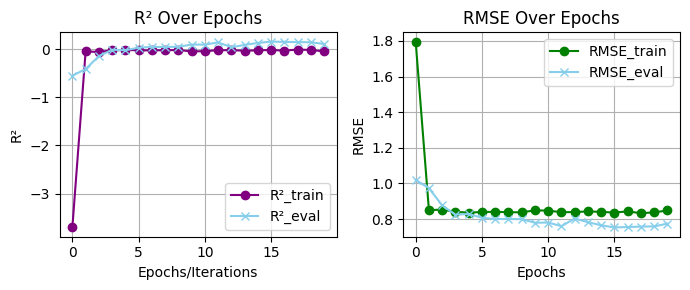

In [ ]:
# train and eval the model

model, r2list, rmselist = train_model(LSTM_NeuralModel, dataset, LSTM_Config(), 20)
r2list_eval, rmselist_eval = eval_model(model, LSTM_Config())
plot_training_results(r2list, rmselist, r2list_eval, rmselist_eval)


In [ ]:
# baseline lstm model result

def test_model(model, dataset, config):
    test_data = dataset.get_subset('test')
    test_loader = get_eval_loader('standard', test_data, batch_size=config.B)

    y_true = []
    y_pred = []

    for batch in test_loader:
        x_batch, y_batch = batch
        predictions = model(x_batch, training=False)
        y_true.extend(y_batch.numpy().flatten())
        y_pred.extend(predictions.numpy().flatten())
    r2 = r2_score(y_true, y_pred)
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    return r2, rmse

r2, rmse = test_model(model, dataset, LSTM_Config())
print(f'R²: {r2:.4f}')
print(f'RMSE: {rmse:.4f}')



## Fine-tunning the lstm model

In [ ]:
# update the __init__ to update the hyper-parameters

class LSTM_Config():
    B, W, C = 32,32,9
    H = 32 #all season lengths will be 32
    loss_lambda = 0.75
    lstm_layers = 1
    lstm_H = 200
    dense = 356
    season_len = 32

    train_step = 10000000
    lr = 0.005
    #keep probability
    drop_out = 0.75

    # update the hyper-parameters for grid-search
    def __init__(self, season_frac=None, lstm_H=None, drop_out=None, lr=None): # update
        if season_frac is not None:
            self.H = int(season_frac *self.H)
        if lstm_H is not None:
            self.lstm_H = lstm_H
        if drop_out is not None:
            self.drop_out = drop_out
        if lr is not None:
            self.lr = lr

def dense(input_data, H, N=None, name = "dense"):
    if not N:
        N = input_data.get_shape()[-1]
    with tf.variable_scope(name):
        W = tf.get_variable("W", [N, H], initializer=tf.contrib.layers.variance_scaling_initializer())
        b = tf.get_variable("b", [1, H])
        tf.summary.histogram(name + ".W", W)
        tf.summary.histogram(name + ".b", b)
        return tf.matmul(input_data, W, name="matmul") + b

def lstm_net(input_data,output_data,config,keep_prob = 1,name="lstm_net"):
    with tf.variable_scope(name):
        lstm_cell = tf.nn.rnn_cell.LSTMCell(config.lstm_H,state_is_tuple=True)
        lstm_cell = tf.nn.rnn_cell.DropoutWrapper(lstm_cell, output_keep_prob=keep_prob)
        cell = tf.nn.rnn_cell.MultiRNNCell([lstm_cell] * config.lstm_layers,state_is_tuple=True)
        state = cell.zero_state(config.B, tf.float32)
        outputs, final_state = tf.nn.dynamic_rnn(cell, input_data,
                       initial_state=state, time_major=True)
        tf.summary.histogram(name + '.outputs', outputs)
        output_final = tf.squeeze(tf.slice(outputs, [config.H-1,0,0] , [1,-1,-1]))
        tf.summary.histogram(name + '.output_final', output_final)
        fc1 = dense(output_final, config.dense, name="dense")

        logit = tf.squeeze(dense(fc1,1,name='logit'))
        tf.summary.histogram(name + '.logit', logit)
        loss_err = tf.nn.l2_loss(logit - output_data)
        loss_reg = tf.add_n([tf.nn.l2_loss(v) for v in tf.trainable_variables()])
        total_loss = config.loss_lambda * loss_err + (1 - config.loss_lambda) * loss_reg

        tf.summary.scalar(name + '.loss_err', loss_err)
        tf.summary.scalar(name + '.loss_reg', loss_reg)
        tf.summary.scalar(name + '.loss_total', total_loss)

        return logit,total_loss,fc1

class LSTM_NeuralModel(tf.keras.Model):
    def __init__(self, config, name="LSTM_Model"):
        super(LSTM_NeuralModel, self).__init__(name=name)
        self.config = config
        self.lstm = tf.keras.layers.LSTM(
            units=config.lstm_H,
            return_sequences=False,
            return_state=False,
            dropout=1 - config.drop_out,
        )
        self.dense1 = tf.keras.layers.Dense(config.dense, activation="relu")
        self.logit = tf.keras.layers.Dense(1, activation=None)

    def call(self, inputs, training=False):
        x = tf.transpose(inputs, perm=[2, 0, 1, 3])
        x = tf.reshape(x, [-1, self.config.W, self.config.H * self.config.C])

        # LSTM layer
        x = self.lstm(x, training=training)

        # Dense layer
        x = self.dense1(x)
        output = self.logit(x)

        return output



In [ ]:


drop_outs = [0.5, 0.75]
learning_rates = [0.1, 0.01, 0.005]
lstm_units = [200, 300]

param_grid = list(itertools.product(drop_outs, learning_rates, lstm_units))

best_rmse = 100
best_params = None

for drop_out, lr, lstm_H in param_grid:
    print(f'Training with dropout={drop_out}, lr={lr}, lstm_H={lstm_H}')
    config = LSTM_Config(lstm_H=lstm_H, drop_out=drop_out, lr=lr)
    model = LSTM_NeuralModel(config)

    trained_model,_,_ = train_model(model,dataset, config, num_epochs=15) #epochs to 15 according to the val pattern
    r2_value, rmse_value = test_model(trained_model, dataset, config)

    # Check if this combination gives a better RMSE
    if rmse_value < best_rmse:
        best_rmse = rmse_value
        best_params = (drop_out, lr, lstm_H)

    print(f'RMSE for this set: {rmse_value}')

print('\nBest parameters:')
print(f'Drop out rate: {best_params[0]}')
print(f'Learning rate: {best_params[1]}')
print(f'LSTM units: {best_params[2]}')
print(f'Best RMSE: {best_rmse}')

Training with dropout=0.75, lr=0.1, lstm_H=200
Epoch 1, Batch 1, Loss: 7.7069549560546875
Epoch 1, Batch 2, Loss: 38538.1015625
Epoch 1, Batch 3, Loss: 2786.58740234375
Epoch 1, Batch 4, Loss: 14.428361892700195
Epoch 1, Batch 5, Loss: 39.066932678222656
Epoch 1, Batch 6, Loss: 337.958740234375
Epoch 1, Batch 7, Loss: 10.643880844116211
Epoch 1, Batch 8, Loss: 10.359560012817383
Epoch 1, Batch 9, Loss: 10.487308502197266
Epoch 1, Batch 10, Loss: 6.204424858093262
Epoch 1, Batch 11, Loss: 3.012660026550293
Epoch 1, Batch 12, Loss: 0.8946355581283569
Epoch 1, Batch 13, Loss: 4.892642021179199
Epoch 1, Batch 14, Loss: 2.6870572566986084
Epoch 1, Batch 15, Loss: 1.1602532863616943
Epoch 1, Batch 16, Loss: 0.939075767993927
Epoch 1, Batch 17, Loss: 1.297715663909912
Epoch 1, Batch 18, Loss: 1.8347899913787842
Epoch 1, Batch 19, Loss: 2.895655632019043
Epoch 1, Batch 20, Loss: 2.8737807273864746
Epoch 1, Batch 21, Loss: 1.9828583002090454
Epoch 1, Batch 22, Loss: 0.7930763959884644
Epoch 1, 

ERROR:tensorflow:==================================
Object was never used (type <class 'tensorflow.python.ops.tensor_array_ops.TensorArray'>):
If you want to mark it as used call its "mark_used()" method.
It was originally created here:
  File "/usr/local/lib/python3.10/dist-packages/keras/src/backend/tensorflow/rnn.py", line 418, in <genexpr>
    output_ta_t = tuple(  File "/usr/local/lib/python3.10/dist-packages/tensorflow/python/util/tf_should_use.py", line 288, in wrapped
    return _add_should_use_warning(fn(*args, **kwargs),
ERROR:tensorflow:==================================
Object was never used (type <class 'tensorflow.python.ops.tensor_array_ops.TensorArray'>):
If you want to mark it as used call its "mark_used()" method.
It was originally created here:
  File "/usr/local/lib/python3.10/dist-packages/keras/src/backend/tensorflow/rnn.py", line 418, in <genexpr>
    output_ta_t = tuple(  File "/usr/local/lib/python3.10/dist-packages/tensorflow/python/util/tf_should_use.py", lin

Epoch 12, Batch 31, Loss: 0.5896695852279663
Epoch 12, Batch 32, Loss: 1.0717189311981201
Epoch 12, Batch 33, Loss: 1.1318480968475342
Epoch 13, Batch 1, Loss: 0.6875051259994507
Epoch 13, Batch 2, Loss: 0.7015473246574402
Epoch 13, Batch 3, Loss: 0.7749155759811401
Epoch 13, Batch 4, Loss: 1.0037440061569214
Epoch 13, Batch 5, Loss: 0.6222079992294312
Epoch 13, Batch 6, Loss: 0.5860673189163208
Epoch 13, Batch 7, Loss: 0.6440155506134033
Epoch 13, Batch 8, Loss: 0.6710919737815857
Epoch 13, Batch 9, Loss: 0.6054389476776123
Epoch 13, Batch 10, Loss: 0.6091039180755615
Epoch 13, Batch 11, Loss: 0.6558399200439453
Epoch 13, Batch 12, Loss: 0.714393138885498
Epoch 13, Batch 13, Loss: 0.5591267347335815
Epoch 13, Batch 14, Loss: 0.7454805970191956
Epoch 13, Batch 15, Loss: 0.9250683784484863
Epoch 13, Batch 16, Loss: 0.7648913264274597
Epoch 13, Batch 17, Loss: 1.0305302143096924
Epoch 13, Batch 18, Loss: 0.7169872522354126
Epoch 13, Batch 19, Loss: 0.872818112373352
Epoch 13, Batch 20, L

Best parameters:

Dropout: 0.75

Learning rate: 0.01

LSTM units: 200

Best RMSE: 0.7785940308011187

# 2. Transfer learning on US Soybean

In [ ]:
config = LSTM_Config(lstm_H=200, drop_out=0.75, lr=0.01)
model = LSTM_NeuralModel(config)
pretrained_model,_,_ = train_model(model, dataset, config, num_epochs=15)


Epoch 1, Batch 1, Loss: 8.444135665893555
Epoch 1, Batch 2, Loss: 4.23391056060791
Epoch 1, Batch 3, Loss: 156.62606811523438
Epoch 1, Batch 4, Loss: 13.155106544494629
Epoch 1, Batch 5, Loss: 2.5904438495635986
Epoch 1, Batch 6, Loss: 5.687861442565918
Epoch 1, Batch 7, Loss: 4.462691307067871
Epoch 1, Batch 8, Loss: 5.401070594787598
Epoch 1, Batch 9, Loss: 3.13135027885437
Epoch 1, Batch 10, Loss: 3.1927878856658936
Epoch 1, Batch 11, Loss: 1.5728464126586914
Epoch 1, Batch 12, Loss: 0.41552990674972534
Epoch 1, Batch 13, Loss: 2.360414981842041
Epoch 1, Batch 14, Loss: 1.2094769477844238
Epoch 1, Batch 15, Loss: 0.8995803594589233
Epoch 1, Batch 16, Loss: 0.6203769445419312
Epoch 1, Batch 17, Loss: 1.0515596866607666
Epoch 1, Batch 18, Loss: 0.9306895136833191
Epoch 1, Batch 19, Loss: 0.6813889741897583
Epoch 1, Batch 20, Loss: 0.5063807964324951
Epoch 1, Batch 21, Loss: 0.7880254983901978
Epoch 1, Batch 22, Loss: 0.5281727910041809
Epoch 1, Batch 23, Loss: 0.5911122560501099
Epoch

In [ ]:
pretrained_model.save_weights('pretrained_model.weights.h5')

In [ ]:
# change the dataset from Argentina to USA

dataset_usa = get_dataset(dataset='crop_yield', download=True, split_scheme='usa')  # change the code in get_dataset to USA data

Epoch 1, Batch 1, Loss: 10.255167007446289
Epoch 1, Batch 2, Loss: 0.8609815835952759
Epoch 1, Batch 3, Loss: 355.6170654296875
Epoch 1, Batch 4, Loss: 24.399566650390625
Epoch 1, Batch 5, Loss: 3.685458183288574
Epoch 1, Batch 6, Loss: 7.410475254058838
Epoch 1, Batch 7, Loss: 10.002830505371094
Epoch 1, Batch 8, Loss: 6.939477443695068
Epoch 1, Batch 9, Loss: 5.5649213790893555
Epoch 1, Batch 10, Loss: 3.798226833343506
Epoch 1, Batch 11, Loss: 1.5659236907958984
Epoch 1, Batch 12, Loss: 0.37722766399383545
Epoch 1, Batch 13, Loss: 1.9394237995147705
Epoch 1, Batch 14, Loss: 0.7858812212944031
Epoch 1, Batch 15, Loss: 0.5056763887405396
Epoch 1, Batch 16, Loss: 0.7146655321121216
Epoch 1, Batch 17, Loss: 1.0617069005966187
Epoch 1, Batch 18, Loss: 0.5120425224304199
Epoch 1, Batch 19, Loss: 0.4185057282447815
Epoch 1, Batch 20, Loss: 0.5436594486236572
Epoch 1, Batch 21, Loss: 0.5753266215324402
Epoch 1, Batch 22, Loss: 0.7148011326789856
Epoch 1, Batch 23, Loss: 0.45950809121131897


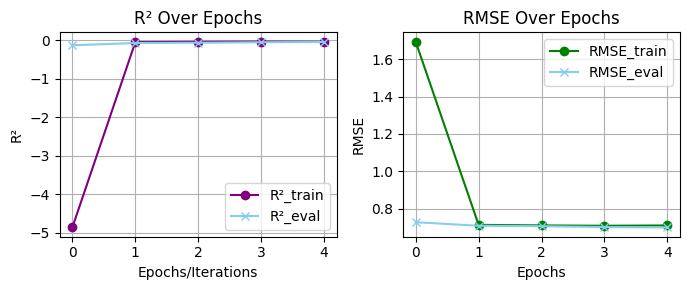

USA transfer learning model R²: -0.0183
USA transfer learning model RMSE: 0.6897


In [ ]:

class TransferModel(tf.keras.Model):
    def __init__(self, pretrained_model, new_dense_units, drop_out=0.75, name='TransferModel'):
        super(TransferModel, self).__init__(name=name)

        # Use the LSTM part from the pretrained model
        self.lstm = pretrained_model.lstm  # LSTM layer from the pretrained model
        self.lstm.trainable = False  # Freeze the LSTM layers

        # Add new dense layers
        self.dense1 = Dense(new_dense_units, activation='relu')
        self.dense2 = Dense(1, activation=None)  # Final output layer

    def call(self, inputs, training=False):
        x = self.lstm(inputs, training=training)  # Pass inputs through frozen LSTM
        x = self.dense1(x)  # Pass through new Dense layer
        output = self.dense2(x)  # Final output layer

        return output


pretrained_model.load_weights('pretrained_model.weights.h5')  # Load pretrained weights

usa_trans_model = TransferModel(pretrained_model, new_dense_units=356, drop_out=0.75)
usa_trans_model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.01), loss='rmse')

usa_trans_model, r2list, rmselist = train_model(usa_trans_model, dataset_usa, config, num_epochs=5)
r2list_eval, rmselist_eval = eval_model(usa_trans_model, dataset_usa, config, 5)
plot_training_results(r2list, rmselist, r2list_eval, rmselist_eval)
r2, rmse = test_model(usa_trans_model, dataset_usa, config)

print(f'USA transfer learning model R²: {r2:.4f}')
print(f'USA transfer learning model RMSE: {rmse:.4f}')

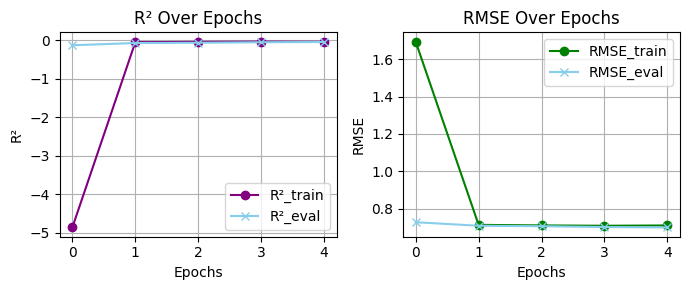

In [ ]:
# modified plot to replace to previous one

plot_training_results(r2list, rmselist, r2list_eval, rmselist_eval)

# 3. Transfer learning on Argentina corn

# 4. Adding new fearture to improve the Argentina lstm model

In [120]:

# 1034 samples in training set


data = np.load('/content/train_keys.npz') #train argentina

split_data = [item.split('_') for item in data['data']]

df = pd.DataFrame(split_data, columns=['Region1', 'Region2', 'Year'])
df.to_csv('output_file.csv', index=False)
df


,Region1,Region2,Year
0,9 de julio,chaco,2007
1,constitucion,santa fe,2014
2,gualeguay,entre rios,2009
3,san martin,santa fe,2015
4,san cristobal,santa fe,2011
...,...,...,...
1029,cruz alta,tucuman,2008
1030,san martin,santa fe,2008
1031,general roca,cordoba,2011
1032,pergamino,buenos aires,2007


In [68]:
# the 'rainfall.csv' is the added rainfall value version of 'output_file.csv'
df_rainfall = pd.read_csv('/content/rainfall.csv')
rf = df_rainfall['Rainfall']
a = rf.tolist()
a

[668.9,
 502.3,
 516.1,
 502.3,
 502.3,
 502.3,
 502.3,
 502.3,
 504.1,
 504.1,
 501.8,
 501.8,
 516.1,
 501.8,
 501.8,
 422.6,
 504.1,
 504.1,
 504.1,
 422.6,
 668.9,
 502.3,
 504.1,
 504.1,
 504.1,
 501.8,
 502.3,
 504.1,
 501.8,
 501.8,
 504.1,
 501.8,
 504.1,
 504.1,
 504.1,
 542.1,
 504.1,
 516.1,
 501.8,
 501.8,
 504.1,
 504.1,
 502.3,
 502.3,
 504.1,
 422.6,
 501.8,
 504.1,
 502.3,
 516.1,
 422.6,
 504.1,
 504.1,
 501.8,
 501.8,
 504.1,
 501.8,
 502.3,
 501.8,
 504.1,
 504.1,
 504.1,
 682.3,
 504.1,
 422.6,
 502.3,
 504.1,
 504.1,
 355.6,
 516.1,
 504.1,
 504.1,
 501.8,
 504.1,
 504.1,
 504.1,
 504.1,
 422.6,
 504.1,
 504.1,
 516.1,
 542.1,
 504.1,
 504.1,
 504.1,
 542.1,
 502.3,
 504.1,
 501.8,
 504.1,
 504.1,
 504.1,
 668.9,
 516.1,
 422.6,
 501.8,
 504.1,
 502.3,
 504.1,
 504.1,
 504.1,
 501.8,
 355.6,
 516.1,
 502.3,
 502.3,
 504.1,
 682.3,
 668.9,
 504.1,
 516.1,
 502.3,
 504.1,
 682.3,
 668.9,
 668.9,
 504.1,
 501.8,
 501.8,
 502.3,
 502.3,
 502.3,
 516.1,
 668.9,
 504.1,


In [116]:


class CustomDataset(Dataset):
    def __init__(self, data, rainfall_data):
        self.data = data  
        self.rainfall_data = rainfall_data  

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        x, y = self.data[idx]
        rainfall = self.rainfall_data[idx]

        # Create a rainfall array of shape (32, 32, 1)
        rainfall = np.full((32, 32, 1), rainfall)        
        x = np.concatenate((x, rainfall), axis=-1)
        x = torch.tensor(x, dtype=torch.float32)
        return x, y


train_data = dataset.get_subset('train')
rainfall_data = a  
train_data_add = CustomDataset(train_data, rainfall_data)

# Create DataLoader
train_loader_add = DataLoader(train_data_add, batch_size=32, shuffle=False)

# Check outputs
for x, y in train_loader_add:
    print(x.shape)


torch.Size([32, 32, 32, 10])
torch.Size([32, 32, 32, 10])
torch.Size([32, 32, 32, 10])
torch.Size([32, 32, 32, 10])
torch.Size([32, 32, 32, 10])
torch.Size([32, 32, 32, 10])
torch.Size([32, 32, 32, 10])
torch.Size([32, 32, 32, 10])
torch.Size([32, 32, 32, 10])
torch.Size([32, 32, 32, 10])
torch.Size([32, 32, 32, 10])
torch.Size([32, 32, 32, 10])
torch.Size([32, 32, 32, 10])
torch.Size([32, 32, 32, 10])
torch.Size([32, 32, 32, 10])
torch.Size([32, 32, 32, 10])
torch.Size([32, 32, 32, 10])
torch.Size([32, 32, 32, 10])
torch.Size([32, 32, 32, 10])
torch.Size([32, 32, 32, 10])
torch.Size([32, 32, 32, 10])
torch.Size([32, 32, 32, 10])
torch.Size([32, 32, 32, 10])
torch.Size([32, 32, 32, 10])
torch.Size([32, 32, 32, 10])
torch.Size([32, 32, 32, 10])
torch.Size([32, 32, 32, 10])
torch.Size([32, 32, 32, 10])
torch.Size([32, 32, 32, 10])
torch.Size([32, 32, 32, 10])
torch.Size([32, 32, 32, 10])
torch.Size([32, 32, 32, 10])
torch.Size([10, 32, 32, 10])


In [109]:

class LSTM_ADD_Config():
    B, W, C = 32,32,10
    H = 32 #all season lengths will be 32
    loss_lambda = 0.75
    lstm_layers = 1
    lstm_H = 200
    dense = 356
    season_len = 32

    train_step = 10000000
    lr = 0.01
    #keep probability
    drop_out = 0.75

    def __init__(self, season_frac=None):
        if season_frac is not None:
            self.H = int(season_frac*self.H)

def dense(input_data, H, N=None, name = "dense"):
    if not N:
        N = input_data.get_shape()[-1]
    with tf.variable_scope(name):
        W = tf.get_variable("W", [N, H], initializer=tf.contrib.layers.variance_scaling_initializer())
        b = tf.get_variable("b", [1, H])
        tf.summary.histogram(name + ".W", W)
        tf.summary.histogram(name + ".b", b)
        return tf.matmul(input_data, W, name="matmul") + b

def lstm_add_net(input_data,output_data,config,keep_prob = 1,name="lstm_add_net"):
    with tf.variable_scope(name):
        lstm_cell = tf.nn.rnn_cell.LSTMCell(config.lstm_H,state_is_tuple=True)
        lstm_cell = tf.nn.rnn_cell.DropoutWrapper(lstm_cell, output_keep_prob=keep_prob)
        cell = tf.nn.rnn_cell.MultiRNNCell([lstm_cell] * config.lstm_layers,state_is_tuple=True)
        state = cell.zero_state(config.B, tf.float32)
        outputs, final_state = tf.nn.dynamic_rnn(cell, input_data,
                       initial_state=state, time_major=True)
        tf.summary.histogram(name + '.outputs', outputs)
        output_final = tf.squeeze(tf.slice(outputs, [config.H-1,0,0] , [1,-1,-1]))
        tf.summary.histogram(name + '.output_final', output_final)
        fc1 = dense(output_final, config.dense, name="dense")

        logit = tf.squeeze(dense(fc1,1,name='logit'))
        tf.summary.histogram(name + '.logit', logit)
        loss_err = tf.nn.l2_loss(logit - output_data)
        loss_reg = tf.add_n([tf.nn.l2_loss(v) for v in tf.trainable_variables()])
        total_loss = config.loss_lambda * loss_err + (1 - config.loss_lambda) * loss_reg

        tf.summary.scalar(name + '.loss_err', loss_err)
        tf.summary.scalar(name + '.loss_reg', loss_reg)
        tf.summary.scalar(name + '.loss_total', total_loss)

        return logit,total_loss,fc1

class LSTM_ADDModel(tf.keras.Model):
    def __init__(self, config, name="LSTM_ADDModel"):
        super(LSTM_ADDModel, self).__init__(name=name)
        self.config = config
        self.lstm = tf.keras.layers.LSTM(
            units=config.lstm_H,
            return_sequences=False,
            return_state=False,
            dropout=1 - config.drop_out,
        )
        self.dense1 = tf.keras.layers.Dense(config.dense, activation="relu")
        self.logit = tf.keras.layers.Dense(1, activation=None)

    def call(self, inputs, training=False):
        x = tf.transpose(inputs, perm=[2, 0, 1, 3])
        x = tf.reshape(x, [-1, self.config.W, self.config.H * self.config.C])

        # LSTM layer
        x = self.lstm(x, training=training)

        # Dense layer
        x = self.dense1(x)
        output = self.logit(x)

        return output



In [110]:

def train_add_model(model, config, num_epochs=2):

    loss_fn = tf.keras.losses.MeanSquaredError()
    optimizer = tf.keras.optimizers.Adam(learning_rate=config.lr)

    train_loader = train_loader_add

    model = LSTM_ADDModel(config)
    r2list = []
    rmselist = []

    for epoch in range(num_epochs):
    # Iterate through the train_loader to access batches of data
        y_true = []
        y_pred = []
        batch_size = config.B
        for batch_idx, (batch_x, batch_y) in enumerate(train_loader):
            with tf.GradientTape() as tape:
                predictions = model(batch_x, training=True)
                loss = loss_fn(batch_y, predictions)

            gradients = tape.gradient(loss, model.trainable_variables)
            optimizer.apply_gradients(zip(gradients, model.trainable_variables))
            y_true.extend(batch_y.numpy().flatten())
            y_pred.extend(predictions.numpy().flatten())
            print(f"Epoch {epoch + 1}, Batch {batch_idx + 1}, Loss: {loss.numpy()}")

        r2 = r2_score(y_true, y_pred)
        rmse = np.sqrt(mean_squared_error(y_true, y_pred))
        r2list.append(r2)
        rmselist.append(rmse)
    return model, r2list, rmselist



Epoch 1, Batch 1, Loss: 7.172255516052246
Epoch 1, Batch 2, Loss: 5.087353706359863
Epoch 1, Batch 3, Loss: 3.425551414489746
Epoch 1, Batch 4, Loss: 1.5421671867370605
Epoch 1, Batch 5, Loss: 0.665388822555542
Epoch 1, Batch 6, Loss: 1.0005890130996704
Epoch 1, Batch 7, Loss: 0.9293491840362549
Epoch 1, Batch 8, Loss: 0.861047625541687
Epoch 1, Batch 9, Loss: 0.7611544728279114
Epoch 1, Batch 10, Loss: 0.9766716957092285
Epoch 1, Batch 11, Loss: 0.949386477470398
Epoch 1, Batch 12, Loss: 0.7636209726333618
Epoch 1, Batch 13, Loss: 1.0048158168792725
Epoch 1, Batch 14, Loss: 0.7253059148788452
Epoch 1, Batch 15, Loss: 0.6954406499862671
Epoch 1, Batch 16, Loss: 0.7764778137207031
Epoch 1, Batch 17, Loss: 0.9878766536712646
Epoch 1, Batch 18, Loss: 0.9826576709747314
Epoch 1, Batch 19, Loss: 1.097381353378296
Epoch 1, Batch 20, Loss: 0.6760913133621216
Epoch 1, Batch 21, Loss: 1.229600191116333
Epoch 1, Batch 22, Loss: 0.9220498204231262
Epoch 1, Batch 23, Loss: 0.6088199019432068
Epoch

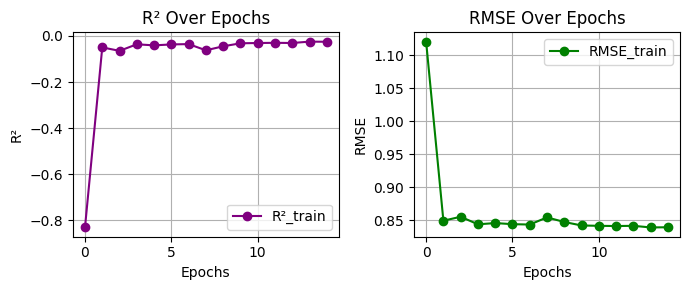

In [118]:
model, r2list, rmselist = train_add_model(LSTM_ADDModel, LSTM_ADD_Config(), num_epochs=15)


fig, axes = plt.subplots(1, 2, figsize=(7, 3))

    # Plot R2
axes[0].plot(r2list, label='R²_train', color='purple', marker='o')
axes[0].set_title('R² Over Epochs')
axes[0].set_xlabel('Epochs')
axes[0].set_ylabel('R²')
axes[0].grid(True)
axes[0].legend()


axes[1].plot(rmselist, label='RMSE_train', color='green', marker='o')
axes[1].set_title('RMSE Over Epochs')
axes[1].set_xlabel('Epochs')
axes[1].set_ylabel('RMSE')
axes[1].grid(True)
axes[1].legend()

plt.tight_layout()
plt.show()